In [127]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

from pandas import Series, DataFrame 
 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.metrics import euclidean_distances

%matplotlib inline

### Загрузка данных

In [128]:
X = pd.read_csv('/content/X_a.csv')
Y = pd.read_csv('/content/Y_a.csv')
test = pd.read_csv('/content/test_a.csv')
target = pd.read_csv('/content/target_a.csv')

In [129]:
def delete_column(data): # удаление лишнего столбца
    return data.drop('Unnamed: 0', axis=1)

Предобрабатываю данные, удаляю лишнюю колонку, target делаю списком:

In [130]:
X = delete_column(X)
Y = delete_column(Y)
test = delete_column(test)
target = delete_column(target)
target = target['income'].values
y = []
for i in Y['income']:
  y.append(i)
y = np.array(y)

In [131]:
X = normalize(X, norm="max", axis=0)
test = normalize(test, norm ='max',axis=0)

Для получения оценок работы моделе напишем функцию metrics, которая вычисляет Confusion Matrix,  Accuracy, Recall, Precision, ROC_AUC curve.

In [132]:
def metrics(model, X, y):
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    figure = plt.figure(figsize = (20, 10))
    matr = confusion_matrix(y, y_pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matr).plot(ax = ax)
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true = y, y_pred = y_pred, name = "ROC-curve", ax = ax)
    plt.show()

def best_params(model):
  print("Best parametres:", model.best_params_)
  print("Best accuracy:", model.best_score_)                   

### Описание классов для всех четырех моделей:

In [152]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx

    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db


class BinaryCrossEntropy:
    def forward(self, p, y):
        y = y.reshape((y.shape[0], 1))
        self.p = p
        self.y = y
        res = y * np.log(p) + (1 - y) * np.log(1 - p)
        return -np.mean(res)

    def backward(self, loss):
        res = (self.p - self.y) / (self.p * (1 - self.p))
        return res / self.p.shape[0]

    
class Sigmoid:
    def forward(self, x):
        self.x = x
        y = 1. / (1. + np.exp(-x) ) 
        return y
    def backward(self, dy):
        y = (np.exp(-self.x) / ((1. + np.exp(-self.x))**2))
        return (y) * dy

In [162]:
class Net(ClassifierMixin, BaseEstimator):
    def __init__(self,epochs = 20, batch_size = 100, sgd_step = 10e-3, alpha = 10e-2,nin = 35,method = "LogReg", k = 3):
      self.method = method
      self.nin = nin
      self.batch_size = batch_size
      self.sgd_step = sgd_step
      self.epochs = epochs
      self.alpha = alpha
      self.k = k
      if method == 'LogReg':
          self.init_LogReg()
      if method == 'SVM':
        self.init_SVM()


    def init_LogReg(self):
        self.layers = []
        self.layers.append(Linear(self.nin,1))
        self.layers.append(Sigmoid())
    
    def init_SVM(self):
        sigma = 1.0 / np.sqrt(self.nin)
        self.W = np.random.normal(0., sigma, (1, self.nin + 1))
    
    def add_ones(self, x):
        ones = np.ones((x.shape[0], 1))
        return np.hstack((x, ones))
    
    def fit(self,x,y):
        x,y = check_X_y(x,y)
        self.x_ = x
        self.y_ = y
        self.is_fitted_ = True
        if self.method == 'LogReg':
          for _ in range(self.epochs):
            self.train_epoch(train_x = x,train_labels = y, batch_size = self.batch_size, lr = self.sgd_step)
        elif self.method == 'SVM':
          for _ in range(self.epochs):
            self.train_epoch_SVM(train_x = x,train_labels = y, batch_size = self.batch_size, lr = self.sgd_step)
    
    def predict_KNN(self,x):
        y = np.ndarray((x.shape[0],))
        for (i, elem) in enumerate(x):
            distances = euclidean_distances([elem], self.x_)[0]
            indexes = np.argsort(distances, kind='heapsort')

            indexes = indexes[:self.k]
            labels, cnts = np.unique(self.y_[indexes], return_counts=True)
            y[i] = labels[cnts.argmax()]
        return y
  

    def predict(self, x):
    
      check_is_fitted(self,['x_','y_'])
      x = check_array(x)
      if self.method == 'KNN':
        return self.predict_KNN(x)
      if self.method == 'SVM':
        res = self.forward_SVM(self.add_ones(x))
        return np.where(res < 0, 0, 1)
      elif self.method == 'LogReg':
        y = self.forward(x)
        res = np.where(y < 0.5, 0, 1)
        return res

            
    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x


    def forward_SVM(self, x):
        z = np.dot(x, self.W.T)
        return z

    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z

    def update(self, lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)


    def train_epoch(self, train_x, train_labels, loss=BinaryCrossEntropy(), batch_size=100, lr=0.01):
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            p = self.forward(xb)
            l = loss.forward(p, yb)
            dp = loss.backward(l)
            dx = self.backward(dp)
            self.update(lr)
    
    def train_epoch_SVM(self, train_x, train_labels, batch_size=100, lr=1e-7):
        train_x = self.add_ones(train_x)
        train_labels = np.where(train_labels > 0, 1, -1)
        for i in range(0, len(train_x), batch_size):
            xb = train_x[i:i + batch_size]
            yb = train_labels[i:i + batch_size]

            pred = self.forward_SVM(xb)
            grad = self.alpha * self.W
            for i in range(len(xb)):
                if (yb[i] * pred[i] < 1):
                    grad -= yb[i] * xb[i]
            self.W -= lr * grad


class NaiveBayes(ClassifierMixin, BaseEstimator):
    def __init__(self):
        None

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.is_fitted_ = True

        labels, cnts = np.unique(self.y_, return_counts=True)
        self.labels = labels
        self.p_of_y = np.array([elem / self.y_.shape[0] for elem in cnts])
        self.means = np.array([self.X_[self.y_ == elem].mean(axis=0) for elem in labels])
        self.stds = np.array([self.X_[self.y_ == elem].std(axis=0) for elem in labels])
        return self

    def gaussian(self, mu, sigma, x0):
        if(sigma ==0):
          sigma = 10e-4
        return np.exp(-(x0 - mu) ** 2 / (2 * sigma)) / np.sqrt(2.0 * np.pi * sigma)

    def predict(self, X):
        check_is_fitted(self, ['X_', 'y_'])

        X = check_array(X)

        res = np.zeros(X.shape[0])
        for (i, elem) in enumerate(X):
            p = np.array(self.p_of_y)
            for (j, label) in enumerate(self.labels):
                p_x_cond_y = np.array(
                    [self.gaussian(self.means[j][k], self.stds[j][k], elem[k]) for k in range(X.shape[1])])
                p[j] *= np.prod(p_x_cond_y)
            res[i] = np.argmax(p)
        return res

###Логистическая регрессия

In [135]:
gscv = GridSearchCV(Pipeline([("logreg", Net(method = 'LogReg', nin=X.shape[1]))]),
                    {"logreg__epochs" : [1, 2, 4],
                     "logreg__batch_size" : [5, 10, 20],
                     "logreg__sgd_step" : [0.01, 0.05, 0.1]})
gscv.fit(X, y)
best_params(gscv)

Best parametres: {'logreg__batch_size': 10, 'logreg__epochs': 4, 'logreg__sgd_step': 0.05}
Best accuracy: 0.8266944140447136


Accuracy: 0.8220011055831952
Precision: 0.7114183764495986
Recall: 0.41471658866354655


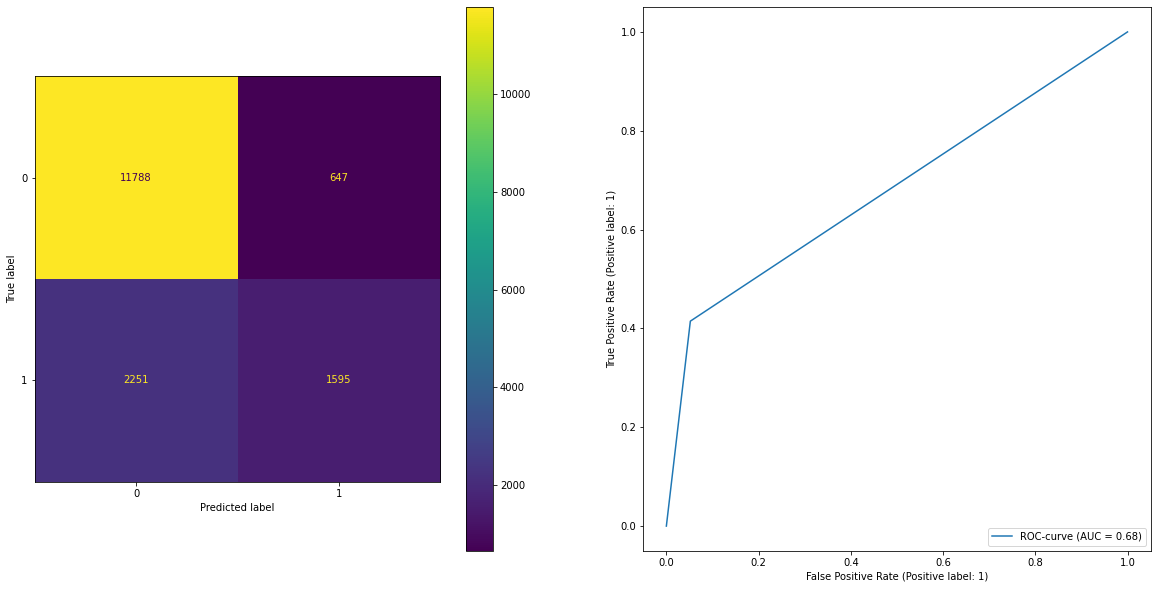

In [136]:
log_reg = gscv.best_estimator_
metrics(log_reg, test, target)

In [137]:
f = open("Logistic_Regression.pkl", "wb")
pickle.dump(gscv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)
f.close()

Сравниим с логистической регрессий из SKlearn

In [138]:
gscv = GridSearchCV(Pipeline([("logreg", LogisticRegression())]),
                    {"logreg__penalty" : ["l2", "none"],
                     "logreg__solver" : ["newton-cg", "lbfgs"],
                     "logreg__max_iter" : [1000, 10000]})
gscv.fit(X, y)
best_params(gscv)

Best parametres: {'logreg__max_iter': 1000, 'logreg__penalty': 'none', 'logreg__solver': 'newton-cg'}
Best accuracy: 0.8462578905692679


Accuracy: 0.8422087095387262
Precision: 0.7116340735830295
Recall: 0.5582423296931878


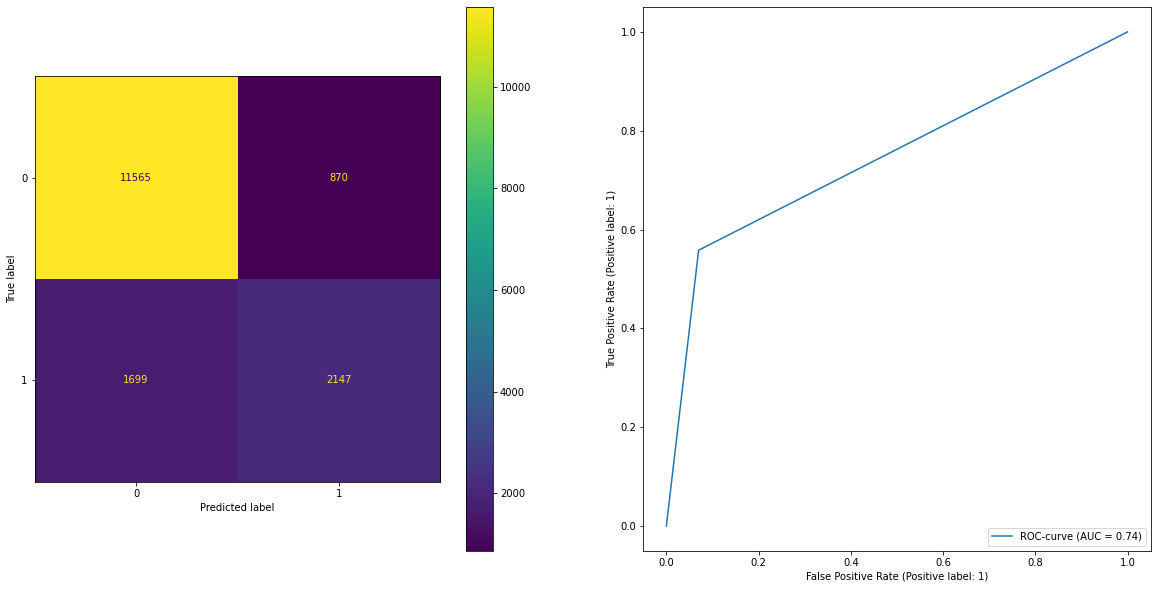

In [139]:
log_reg_sk = gscv.best_estimator_
metrics(log_reg_sk, test, target)

###KNN
Теперь переходим к проверке метода ближайших соседей.

In [140]:
gscv = GridSearchCV(Pipeline([('knn',Net(method = 'KNN', nin=X.shape[1]))]), {'knn__k' : [1, 3, 5, 7, 9]})
gscv.fit(X, y)
best_params(gscv)

Best parametres: {'knn__k': 9}
Best accuracy: 0.8288137389933796


Accuracy: 0.8062158344082059
Precision: 0.6424742268041237
Recall: 0.4050962038481539


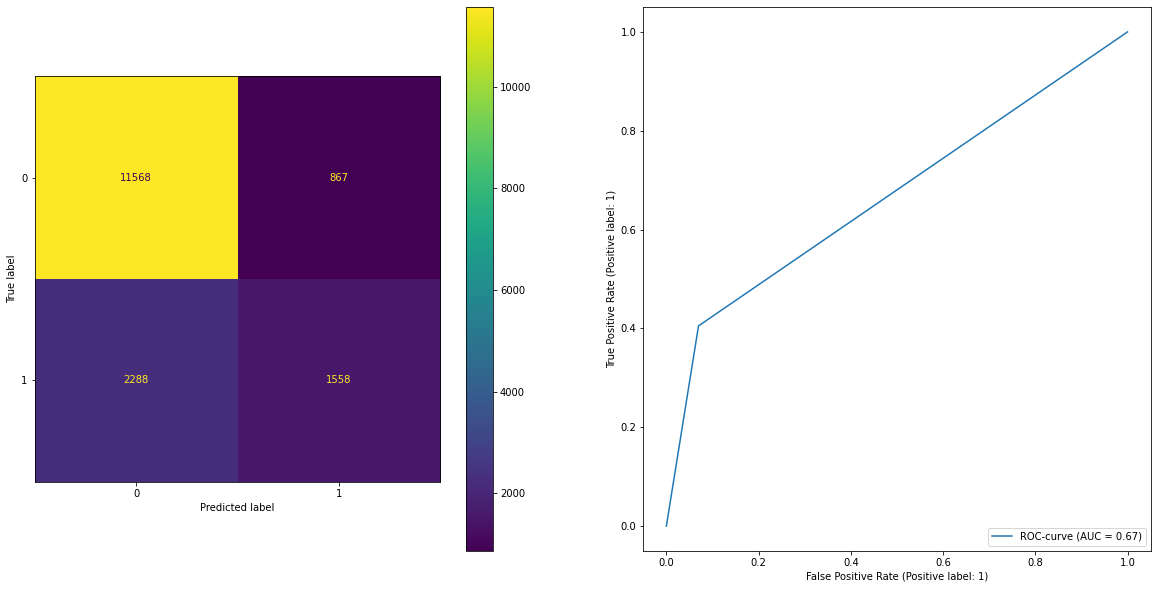

In [141]:
knn = gscv.best_estimator_
metrics(knn, test, target)

In [142]:
f = open("kNN.pkl", "wb")
pickle.dump(gscv.best_estimator_, f, pickle.HIGHEST_PROTOCOL)
f.close()

Посмотрим на "коробочное" решение:

In [143]:
gscv = GridSearchCV(Pipeline([('knn', KNeighborsClassifier())]), {'knn__n_neighbors' : [1, 3, 5, 7, 9]})
gscv.fit(X, y)
best_params(gscv)

Best parametres: {'knn__n_neighbors': 7}
Best accuracy: 0.8285373215013934


Accuracy: 0.80603157054235
Precision: 0.6340607950116913
Recall: 0.42303692147685906


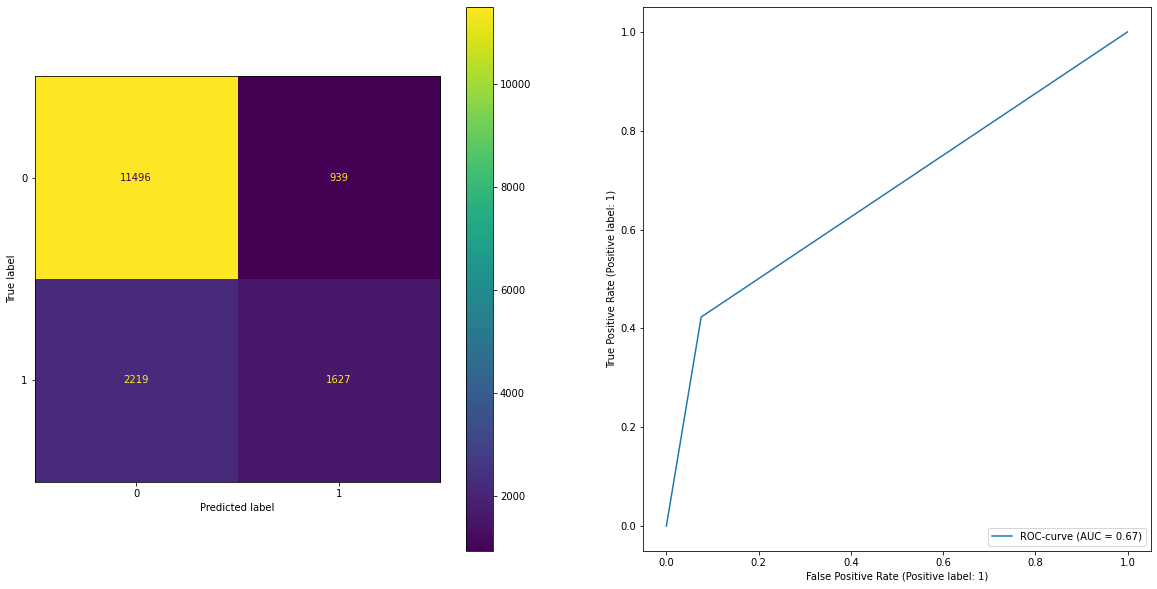

In [144]:
knn = gscv.best_estimator_
metrics(knn, test, target)

###SVM
Посмотрим на результаты метода опорных векторов:

In [145]:
gscv = GridSearchCV(Pipeline([("SVM", Net(method = 'SVM', nin=X.shape[1]))]),
                    {"SVM__epochs" : [1, 2, 4],
                     "SVM__batch_size" : [5, 10, 20],
                     "SVM__sgd_step" : [0.01, 0.05, 0.1],
                     "SVM__alpha" : [1.0, 0.1, 0.01, 0.0]})
gscv.fit(X, y)
best_params(gscv)

Best parametres: {'SVM__alpha': 0.0, 'SVM__batch_size': 10, 'SVM__epochs': 4, 'SVM__sgd_step': 0.01}
Best accuracy: 0.8191083387939676


Accuracy: 0.83078434985566
Precision: 0.7231083844580777
Recall: 0.4596983879355174


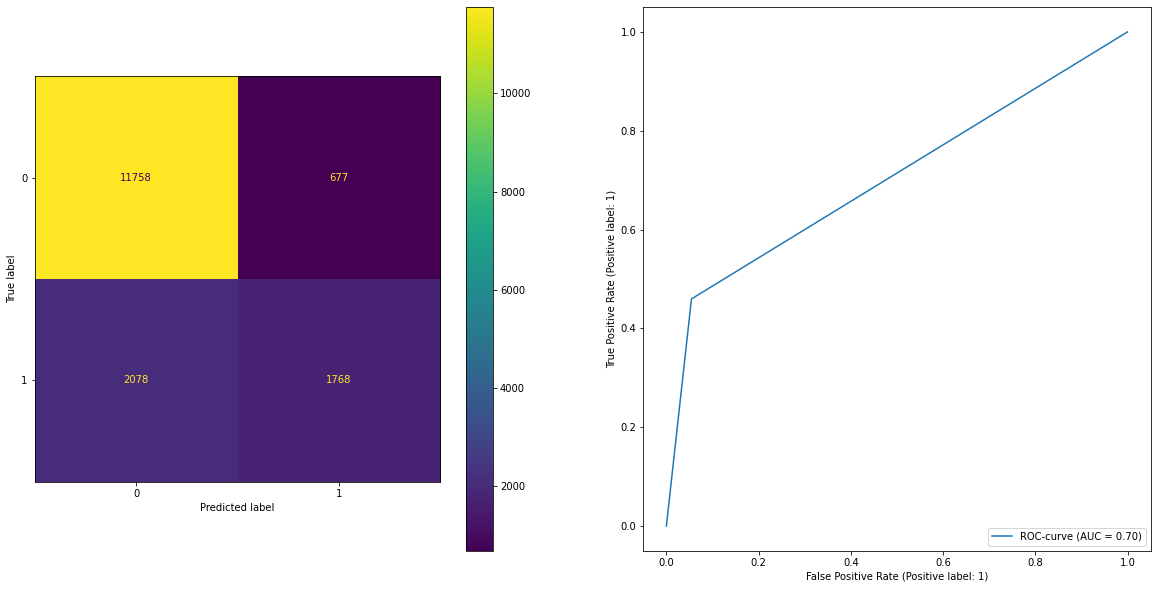

In [146]:
SVM = gscv.best_estimator_
metrics(SVM, test, target)

In [147]:
f = open("SVM.pkl", "wb")
pickle.dump(SVM, f, pickle.HIGHEST_PROTOCOL)
f.close()

Теперт посмотрим на решение из коробки:

In [148]:
gscv = GridSearchCV(Pipeline([("svc", LinearSVC())]),
                    {"svc__loss" : ["hinge", "squared_hinge"],
                     "svc__max_iter" : [1e5, 1e6]})
gscv.fit(X, y)
best_params(gscv)

Best parametres: {'svc__loss': 'squared_hinge', 'svc__max_iter': 100000.0}
Best accuracy: 0.8465343033456806


Accuracy: 0.8431914501566243
Precision: 0.7239348804987876
Recall: 0.5434217368694748


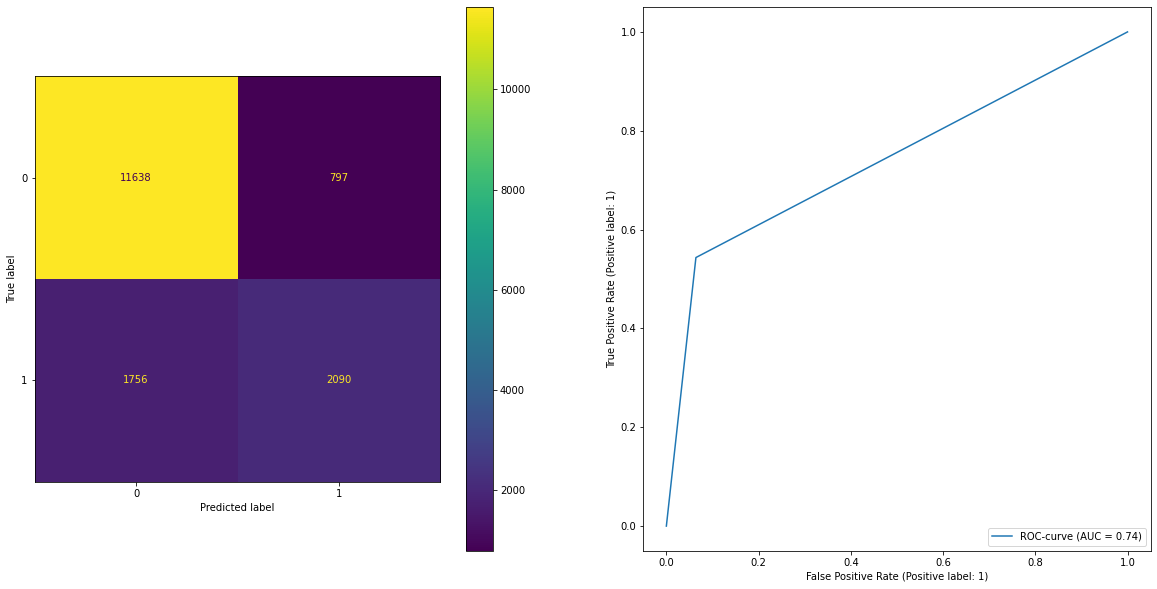

In [149]:
SVM = gscv.best_estimator_
metrics(SVM, test, target)

###NaiveBayes
Теперь проверим работоспособность наивного Байеса:

Accuracy: 0.6090534979423868
Precision: 0.37122993558940803
Recall: 0.9440977639105564


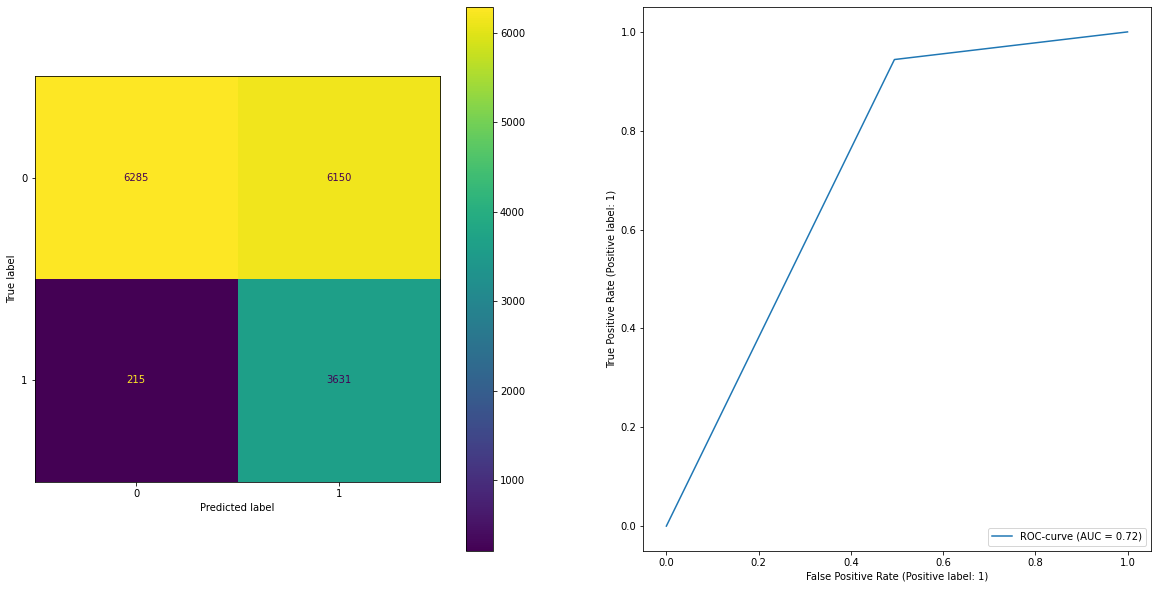

In [164]:
Naive_Bayes = Pipeline([("NB", NaiveBayes())])
Naive_Bayes.fit(X, y)
metrics(Naive_Bayes, test, target)

Сравним с "коробочным" Байесом

Accuracy: 0.5850377740925005
Precision: 0.35701650943396224
Recall: 0.9446177847113885


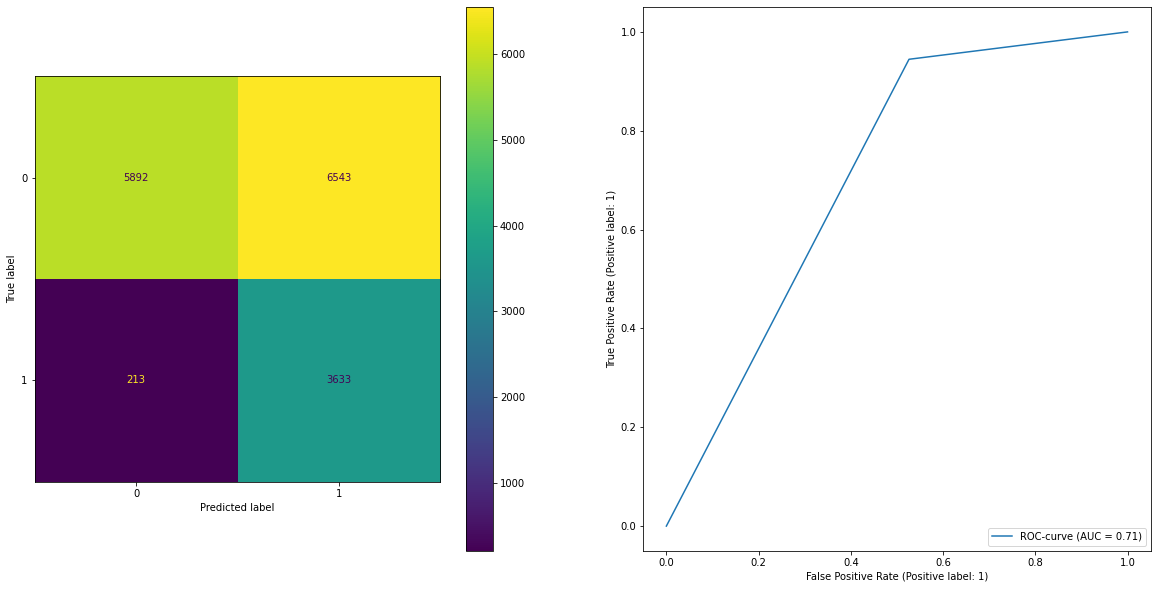

In [163]:
Naive_Bayes = Pipeline([("NB", GaussianNB())])
Naive_Bayes.fit(X, y)
metrics(Naive_Bayes, test, target)